In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
import mlflow.sklearn
import seaborn as sns
from sklearn.datasets import load_wine
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
def load_data()-> pd.DataFrame:
     wine_data=load_wine()
     df=pd.DataFrame(wine_data.data,columns=wine_data.feature_names)
     df['target'] = wine_data.target
     return df

In [20]:
def cleaned_data(df:pd.DataFrame) -> pd.DataFrame:
    num_cols = df.select_dtypes(include='number').drop(columns=['target']).columns.to_list()
    q1=df[num_cols].quantile(0.25)
    q3=df[num_cols].quantile(0.75)
    iqr = q3 - q1
    upper_bound=q3+(1.5*iqr)
    lower_bound= q1 - (1.5 * iqr)
    outlier_mask= (df[num_cols] > upper_bound)|(df[num_cols] < lower_bound)
    print("outlier in the dataset:",outlier_mask.sum().sum())
    df_cleaned=df[num_cols].clip(upper=upper_bound,lower=lower_bound,axis=1)
    df_cleaned['target'] = df['target']
    print(f"Data cleaned and clipped. Shape: {df_cleaned.shape}")
    return df_cleaned


In [28]:
def column_(df:pd.DataFrame) -> pd.DataFrame :
    df=df.rename(columns={'od280/od315_of_diluted_wines': 'diluted_wines'})
    cor=df.corr()
    plt.figure(figsize=(10,8))
    s=sns.heatmap(cor, cmap='coolwarm', annot=True, center=0, vmin=-1, vmax=1)
    s.plot()
    plt.title("corelation of features")
    return df
    

outlier in the dataset: 21
Data cleaned and clipped. Shape: (178, 14)
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1

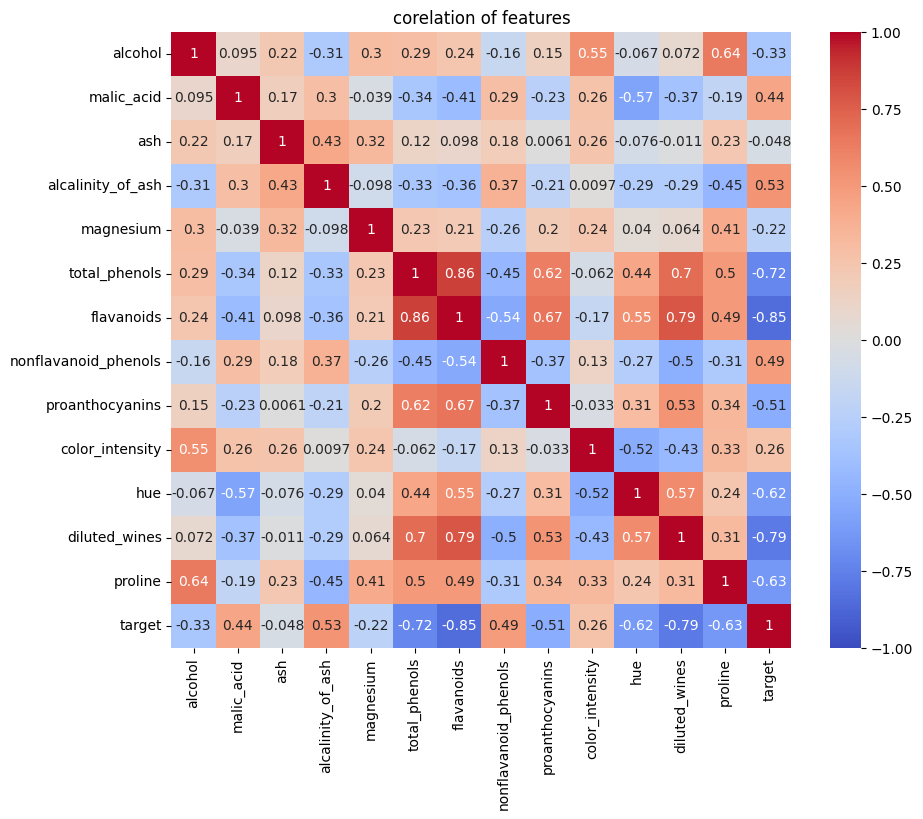

In [29]:
df_raw = load_data()
df_clean= cleaned_data(df_raw)
df_column=column_(df_clean)
print(df_column.head())

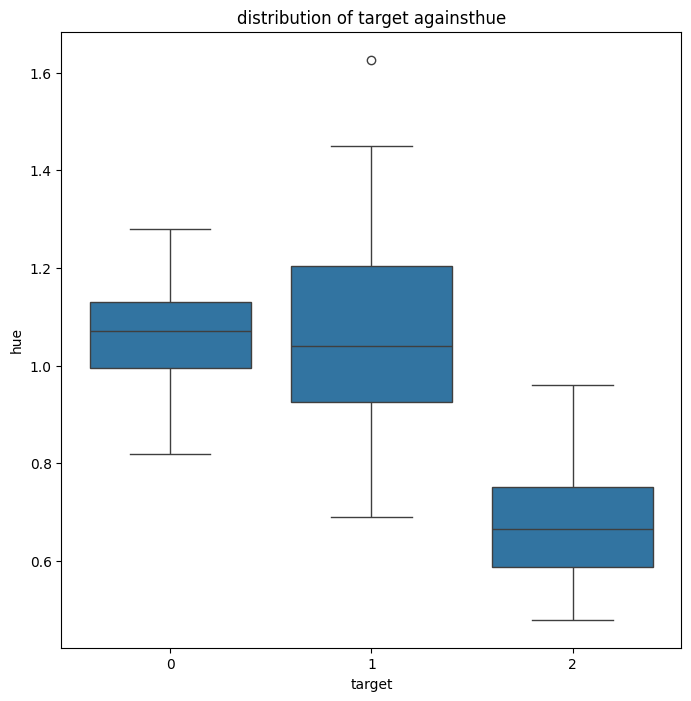

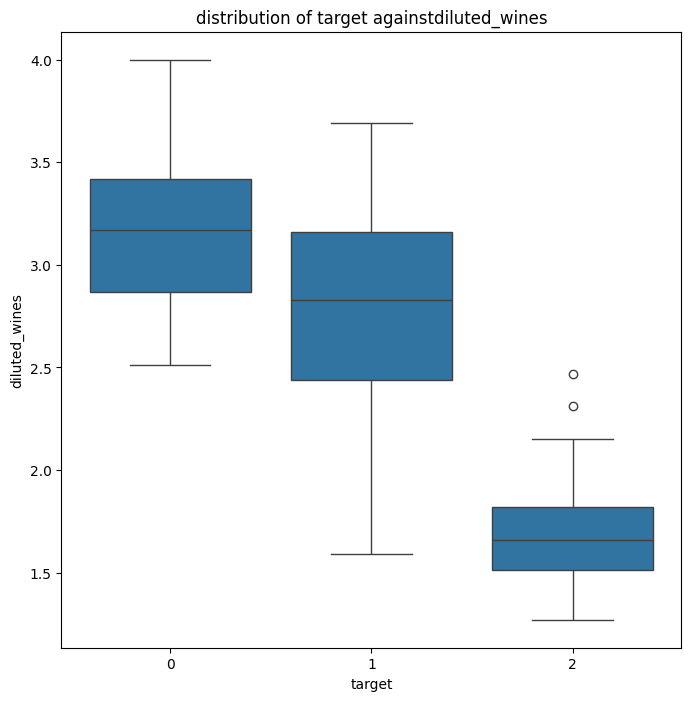

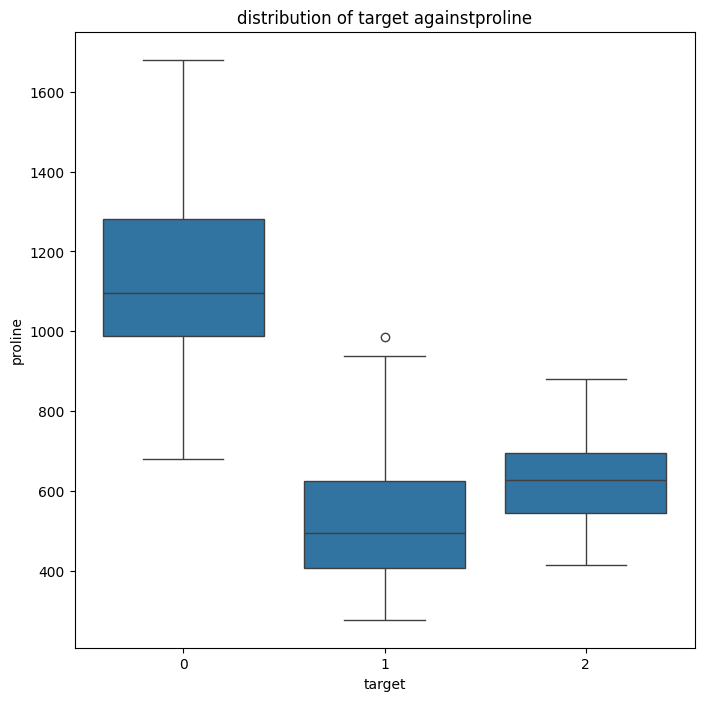

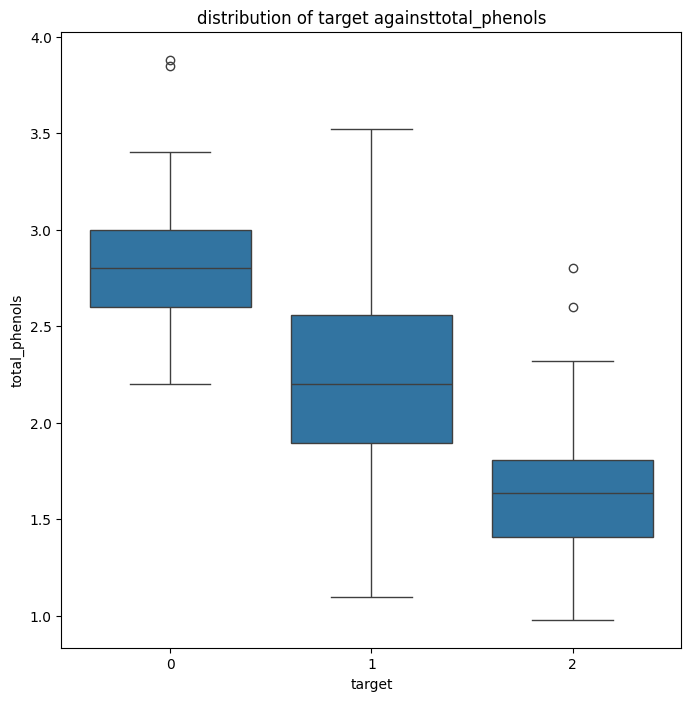

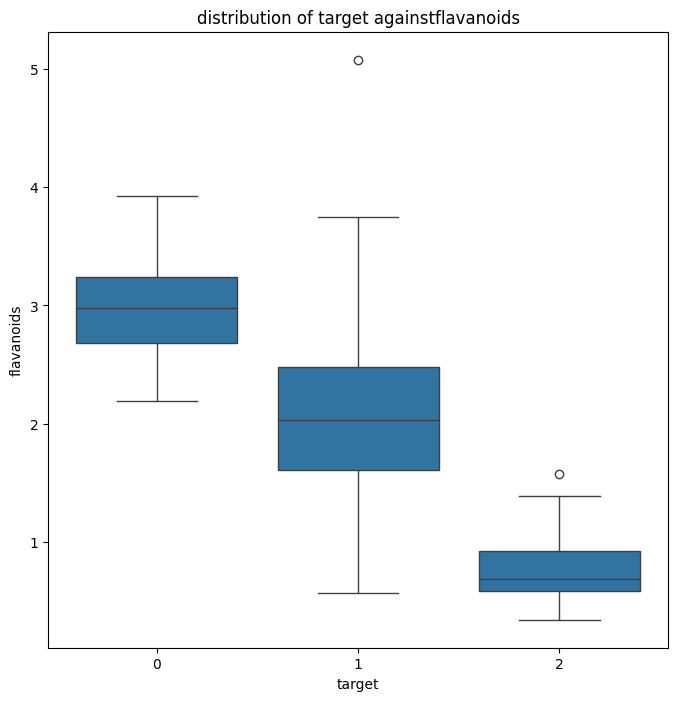

In [57]:
num = ['hue', 'diluted_wines', 'proline', 'total_phenols', 'flavanoids']
for n in num:
    plt.figure(figsize=(8,8))
    sns.boxplot(data=df_column ,x='target',y=n)
    plt.title(f'distribution of target against{n}')
    plt.plot()

<Figure size 800x800 with 0 Axes>

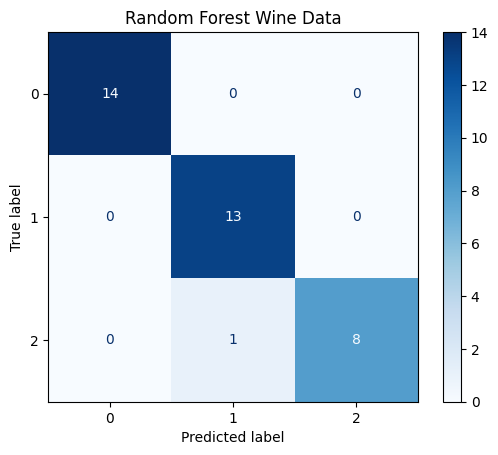

accuracy score is :0.97


In [59]:
mlflow.end_run()
with mlflow.start_run():
    
        x=df_column[num]
        y=df_column['target']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42)


rf = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    max_leaf_nodes=10,        # Changed : to =
    min_impurity_decrease=0.0, # 10 was too high; it would stop the model from growing
    bootstrap=True,
    n_jobs=-1,                 # -1 uses all your CPU cores (faster)
    random_state=42,
    verbose=0,                 # 100 is way too much text; 0 or 1 is better
    max_samples=None           # 9.9 is invalid (must be between 0 and 1.0)
)
rf.fit(x_train,y_train)
y_pred=rf.predict(x_test)
acc=accuracy_score(y_pred,y_test)
cm=confusion_matrix(y_pred,y_test)
cmd=ConfusionMatrixDisplay(confusion_matrix=cm)
cr=classification_report(y_pred,y_test)
with open("classification_report.txt",'w') as f:
        f.write(cr)
mlflow.log_artifact("classification_report.txt")
plt.figure(figsize=(8,8))
cmd.plot(cmap='Blues')
plt.title("random forest wine data ")
plt.savefig("cmd.jpg")
plt.title("Random Forest Wine Data")
plt.savefig("confusion_matrix.png")
mlflow.log_artifact("confusion_matrix.png")
plt.show()
mlflow.log_param('min_samples_leaf',10)
mlflow.log_param(' max_leaf_nodes',10)
print(f"accuracy score is :{acc:.2f}")


In [60]:

mlflow.sklearn.log_model(rf, "wine_rf_model_97")

2025/12/19 22:56:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/19 22:57:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [63]:
import pickle
with open("wine_type.pkl",'wb') as f:
    pickle.dump(rf,f)

print("model saved successfully ")

model saved successfully 


In [66]:
pip install fastapi


[notice] A new release of pip is available: 25.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [72]:
import uvicorn
from fastapi import FastAPI
import pickle 
import nest_asyncio
import pandas as pd  # <--- Yeh missing tha
from pydantic import BaseModel

nest_asyncio.apply()
app = FastAPI()

# Model load karein
with open("wine_type.pkl", 'rb') as f:
    model = pickle.load(f)

# Input class (5 columns as you mentioned)
class wine_input(BaseModel):
    hue: float
    diluted_wines: float
    proline: float
    total_phenols: float
    flavanoids: float

@app.get("/")
def home():
    return {"message": "Wine Prediction API is Running!"}

@app.post("/predict")
def predict(data: wine_input):
    # 1. model_dump() ke saath () lagayein
    # 2. Seedha DataFrame banayein, double list ki zaroorat nahi
    input_df = pd.DataFrame([data.model_dump()])
    
    # 3. Prediction karein
    prediction = model.predict(input_df)

    return {"wine_class": int(prediction[0])}

if __name__ == "__main__":
    uvicorn.run(app, host="127.0.0.1", port=8000)

KeyboardInterrupt: 